# Problem Statement

** Goal: **  The goal of this exercise is to develop a fuzzy record matching program that takes records from “query” set and finds matching record in the “reference” set. 

** Data: ** In the attached excel file, there are two sheets:
 * “reference” sheet  contains a list of restaurants, its address and cuisine (“reference” set) 
 * “query” sheet contains again a list of restaurants, its address and cuisine, plus two additional columns (“query” set)
     * “reference_id” column needs to be populated using the fuzzy record matching program
     * “score(optional)” field can show to what degree the record matches or the confidence of the match. It is optional though

** Guidance: **

 * Please use Java or Python
 * Here’s what we look for in the order of importance:
    * Program runs without errors
    * Efficiency of implementation
    * Coding best practices – comments, tests, packaging,…
    * Program features – batch execution, interactive execution, …
    * Accuracy of the solution 

# Solution Thought process

Concentrating on two parameters for this exercise,
 1. Efficiency/time
 2. Accuracy
 
As there is no labeled test to measure the accuracy for the approach, will be exploring two different solutions,
 * For baseline, 'fuzzywuzzy' python package will be used to measure the parameters.
 * TD-IDF based approach will be explored and compared with the baseline.
 
Note:

This notebook contains complete end-to-end solution with tests and thoughts. Also, below are the steps to run the solution in interactive matter using [Streamlit](https://streamlit.io/) package (very cool package to build interactive demos for data science).

 1. Install dependency packages for the demo (numpy,pandas and sklearn are also required)
 
 `pip install streamlit`
 
 `pip install fuzzywuzzy`
  
 2. Run following command on the terminal to start the server
 
 `git clone https://github.com/pavancs/fuzzy-match-demo.git streamlit-demo`
 
 `cd streamlit-demo`
 
 `streamlit run app.py`
 
 Code will be automatically downloaded from my github and server will be availible at http://localhost:8501 

In [1]:
# import libraries
import re
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/Users/pcs/anaconda3/envs/kaggle/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# import data
reference = pd.read_csv("data/reference.csv")
query = pd.read_csv("data/query.csv")

## Pre-processing data

After first look at the data, there are few pre-processing steps which could improve the results,
 * Handling special characters like, " . " and " ' "
 * Handling text inside (), like mentioning place in column "name" and text (new) in column "cuisine".
 * entity synonyms in column city like "new york city" and "new york"
 
So, let do some exploration on the data and pre-processing to improve the results.

In [3]:
print("Reference data size : %s" % str(reference.shape))
reference.head()

Reference data size : (782, 5)


,id,name,address,city,cuisine
0,1,arnie morton's of chicago,435 s. la cienega blv.,los angeles,american
1,2,art's delicatessen,12224 ventura blvd.,studio city,american
2,3,hotel bel-air,701 stone canyon rd.,bel air,californian
3,4,cafe bizou,14016 ventura blvd.,sherman oaks,french
4,5,campanile,624 s. la brea ave.,los angeles,american


In [4]:
print("Query data size : %s" % str(query.shape))
query.head()

Query data size : (82, 7)


,id,name,address,city,cuisine,reference_id,score(optional)
0,1001,chanterelle,2 harrison st.,new york city,french (new),31.0,70.0
1,1002,daniel,20 e. 76th st.,new york city,french (new),32.0,90.0
2,1003,dawat,210 e. 58th st.,new york city,indian,33.0,90.0
3,1004,felidia,243 e. 58th st.,new york city,italian,NaN,NaN
4,1005,four seasons,99 e. 52nd st.,new york city,american (new),NaN,NaN


In [5]:
# drop reference_id and score(optional) columns
query = query.drop(['reference_id','score(optional)'],axis = 1)

In [6]:
# check for NaN
print("'NaN' in reference data : %s" % reference.isnull().values.any())
print("'NaN' in query data : %s" % query.isnull().values.any())

'NaN' in reference data : False
'NaN' in query data : False


Text pre-processing: 
 * To improve efficiency, Creating a new single column called 'text' with pre-processing to avoid looping.

In [7]:
# pre-process the data

def text_preprocess(row):
    """
    funtion to pre-process with following steps,
        * Handle special characters like, " . " and " ' "
        * Handle text inside ()
        * Handle entity synonyms in column city
    
    args,
        row: dataframe row
    """
    
    entity_synonyms = {'new york city':'new york'}
    
    text = row['name'] + row['address'] + row['city']+ row['cuisine']
    text = re.sub(r'\([^)]*\)', '', text)
    text = text.replace('.','')
    text = text.replace("'",'')
    text = text.replace("`",'')
    text = text.replace(',',' ')
    text = text.replace('&', 'and')
    
    # entity resolution
    for key,value in entity_synonyms.items():
        if key in text:
            text = text.replace(key,value )
    
    text = re.sub(' +', ' ',text)
    text = text.strip()
    
    return text

In [8]:
%%time
reference['text'] = reference.apply(text_preprocess,axis=1)
query['text'] = query.apply(text_preprocess,axis=1)

CPU times: user 43.1 ms, sys: 2.31 ms, total: 45.4 ms
Wall time: 44.7 ms


## Explore solutions for fuzzy logic

 * Use fuzzywuzzy package for baseline interms of accuracy and time to execute

In [9]:
%%time
reference_id = []
score = []
for text in query.text:
    temp = process.extractOne(text,reference.text)
    reference_id.append(temp[2]+1)
    score.append(temp[1])
    
query['reference_id'] = reference_id
query['score'] = score
query = query.drop(['text'],axis = 1)

CPU times: user 1min 23s, sys: 282 ms, total: 1min 23s
Wall time: 1min 23s


In [10]:
# save results
query.to_csv('query_fuzzywuzzy_solution.csv',index = False)

 * TD-IDF for fuzzy logic

In [11]:
# ngram for fuzzy logic

def n_grams(text, n = 3):
    """
    function to character level ngrams
     * add padding to text
     * create character level ngrams
     
    
    args,
        text: text to convert to ngrams
        n : ngrams 'n' value
    """
    
    text = " " + text + " "
    ngrams = zip(*[text[i:] for i in range(n)])
    
    return [''.join(ngram) for ngram in ngrams]

In [12]:
%%time
# create if-idf vector
query['text'] = query.apply(text_preprocess,axis=1)
text = np.concatenate((reference['text'] , query["text"]), axis = None)
text = np.unique(text)
vectorizer = TfidfVectorizer(min_df=1, analyzer=n_grams)
tf_idf_vector = vectorizer.fit(text)
reference_text = tf_idf_vector.transform(reference['text'])
query_text = tf_idf_vector.transform(query['text'])

#get best match
reference_id = []
score = []
for q in query_text:
    reference_id.append(cosine_similarity(q,reference_text).argmax()+1)
    score.append(cosine_similarity(q,reference_text).max())

query['reference_id'] = reference_id
query['score'] = score
query = query.drop(['text'],axis = 1)

CPU times: user 218 ms, sys: 5.4 ms, total: 223 ms
Wall time: 227 ms


In [13]:
# save results
query.to_csv('query_tfidf_solution.csv',index = False)

## Solution comparision and testing

In [14]:
# read results
query_fuzzywuzzy = pd.read_csv('query_fuzzywuzzy_solution.csv')
query_tfidf = pd.read_csv('query_tfidf_solution.csv')

In [15]:
# some stats on both the soltion
print("Percentage match between both solution : %s" % str((sum(query_fuzzywuzzy['reference_id'] == query_tfidf['reference_id']))*100 /
                                                         len(query_fuzzywuzzy['reference_id'])))
print("FuzzyWuzzy, average score: %s" % np.average(query_fuzzywuzzy['score']))
print("FuzzyWuuzy, number of times score > 70: %s / %s" % (sum(query_fuzzywuzzy['score']>70),len(query_fuzzywuzzy['score'])))
print("TF-IDF, average score: %s" % np.average(query_tfidf['score']))
print("TF-IDF, number of times score > 0.6: %s / %s" % (sum(query_tfidf['score']>0.6),len(query_tfidf['score'])))

Percentage match between both solution : 71.95121951219512
FuzzyWuzzy, average score: 92.02439024390245
FuzzyWuuzy, number of times score > 70: 82 / 82
TF-IDF, average score: 0.8334856531595592
TF-IDF, number of times score > 0.6: 78 / 82


Fuzzywuzzy Score Histogram


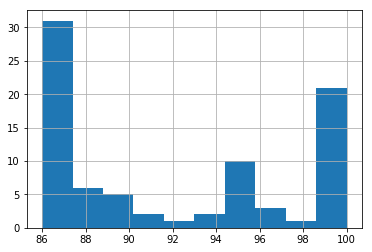

In [23]:
print("Fuzzywuzzy Score Histogram")
query_fuzzywuzzy.score.hist()

TF-IDF Score Histogram


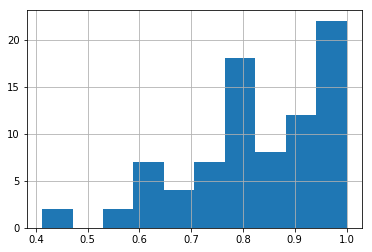

In [17]:
print("TF-IDF Score Histogram")
query_tfidf.score.hist()

** Observations ** :
 * There are cases when both solution are suggesting different text, which are worth exploring.
 * we can't directly compare magnitude of scores of the solutions as the logic is different.
 * For some cases tf-idf score is less (<0.6), which are worth exploring.


In [22]:
# case 1: where both soltions giving different matches
for i,row in query_tfidf[query_fuzzywuzzy['reference_id'] != query_tfidf['reference_id']].iterrows():
    print("----")
    print("Query row,")
    print("----")
    print(row.loc[['id', 'name', 'address', 'city', 'cuisine']])
    matched_text = reference[reference['id'] == row['reference_id']]
    matched_text = matched_text.iloc[0]
    print("----")
    print("TF-IDF matched reference row,")
    print("----")
    print(matched_text)
    matched_text = reference[reference['id'] == query_fuzzywuzzy.loc[i,'reference_id']]
    matched_text = matched_text.iloc[0]
    print("----")
    print("Fuzzywuzzy matched reference row,")
    print("----")
    print(matched_text)
    print("-------------------------------------------------------------------------------")

----
Query row,
----
id                    1001
name           chanterelle
address     2 harrison st.
city         new york city
cuisine       french (new)
Name: 0, dtype: object
----
TF-IDF matched reference row,
----
id                                                        31
name                                             chanterelle
address                      2 harrison st.  near hudson st.
city                                                new york
cuisine                                             american
text       chanterelle 2 harrison st near hudson st new y...
Name: 30, dtype: object
----
Fuzzywuzzy matched reference row,
----
id                                                        29
name                                               carmine's
address            2450 broadway  between 90th and 91st sts.
city                                                new york
cuisine                                              italian
text       carmines 2450 broadway between 

In [19]:
# cases with low tf-idf values
for i,row in query_tfidf[query_tfidf['score']<= 0.6].iterrows():
    print("----")
    print("Query row,")
    print("----")
    print(row.loc[['id', 'name', 'address', 'city', 'cuisine']])
    matched_text = reference[reference['id'] == row['reference_id']]
    matched_text = matched_text.iloc[0]
    print("----")
    print("TF-IDF matched reference row,")
    print("----")
    print(matched_text)
    print("----")
    print("Fuzzywuzzy matched reference row,")
    print("----")
    matched_text = reference[reference['id'] == query_fuzzywuzzy.loc[i,'reference_id']]
    matched_text = matched_text.iloc[0]
    print(matched_text)
    print("-------------------------------------------------------------------------------")

----
Query row,
----
id                    1018
name            mesa grill
address     102 fifth ave.
city         new york city
cuisine       southwestern
Name: 17, dtype: object
----
TF-IDF matched reference row,
----
id                                                        48
name                                              mesa grill
address             102 5th ave.  between 15th and 16th sts.
city                                                new york
cuisine                                             american
text       mesa grill 102 5th ave between 15th and 16th s...
Name: 47, dtype: object
----
Fuzzywuzzy matched reference row,
----
id                                                        23
name                   yujean kang's gourmet chinese cuisine
address                                   67 n. raymond ave.
city                                             los angeles
cuisine                                                asian
text       yujean kangs gourmet chinese c

** Observations : ** 
 * In case 1, clearly tf-idf is performing better. Main reason being, tf-idf gives less importance to more frequent words. Hence, columns like city and cuisine are getting less importance. Which is intuitively correct.
 * In case 2, matches using tf-idf is not bad but there are some uncertainties. So a threshould of 0.6 should be fine. Fuzzywuzzy matches are completely irrelevant.

In [20]:
# test function

def test_random_query(row_idx = []):
    """
    Function to randomly print out best matched reference text
    
    args,
     row_idx : rows index to be tested in an array
    """
    
    for i in row_idx:
        row = query.iloc[i]
        score = row['score']
        print("----")
        print("Query row,")
        print("----")
        print(row.loc[['id', 'name', 'address', 'city', 'cuisine']])
        matched_text = reference[reference['id'] == row['reference_id']]
        matched_text = matched_text.iloc[0]
        print("----")
        print("TF-IDF matched reference row,")
        print("----")
        print(matched_text)
        matched_text = reference[reference['id'] == query_fuzzywuzzy.loc[i,'reference_id']]
        score = query_fuzzywuzzy.loc[i,'score']
        matched_text = matched_text.iloc[0]
        print("----")
        print("Fuzzywuzzy matched reference row,")
        print("----")
        print(matched_text)
        print("-------------------------------------------------------------------------------")
    return

In [21]:
# test some random 5 rows
test_random_query([np.random.randint(len(query)) for i in range(5)])

----
Query row,
----
id                    1035
name          uncle nick's
address     747 ninth ave.
city         new york city
cuisine              greek
Name: 34, dtype: object
----
TF-IDF matched reference row,
----
id                                                        65
name                                            uncle nick's
address             747 9th ave.  between 50th and 51st sts.
city                                                new york
cuisine                                        mediterranean
text       uncle nicks 747 9th ave between 50th and 51st ...
Name: 64, dtype: object
----
Fuzzywuzzy matched reference row,
----
id                                                        23
name                   yujean kang's gourmet chinese cuisine
address                                   67 n. raymond ave.
city                                             los angeles
cuisine                                                asian
text       yujean kangs gourmet chinese c

# Summary

 * Clearly TD-IDF method is performing better interms of both efficiency and accuracy.
 
### Improvements
 * Some more pre-processing steps can be explored to improve the solution further.
 * Generalized entity resolution can improve solution when problem is being solved at large scale.